# We will be using Keras, pretty much the highest-level neural network API.  It can use tensorflow, CNTK, or theano as a backend.  If tensorflow is using a GPU, then it is using the NVIDIA CUDA codebase (another API), which then is calling nearly direct commands on the GPU.  So we could have 3 levels of APIs if we are using Keras on a GPU.

data from here: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

In [1]:
import pandas as pd

In [2]:
filename = '/home/nate/Dropbox/MSDS/MSDS680_ncg_S8W1_18/week5/hour.csv'
# parse dates will convert those columns (labels in the list) to dates

# infer datetime format will try to figure out the datetime format of the dates columns
# and keep using that for the column, so can speed up loading by a lot sometimes
bike_df = pd.read_csv(filename, parse_dates=['dteday'], infer_datetime_format=True)
bike_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# drops the record index 'instant' and date
# also drop casual and registered, because cnt = casual + registered
drop_cols = ['instant', 'dteday', 'casual', 'registered']
bike_df.drop(drop_cols, axis=1, inplace=True)
# if you want, you could engineer more features by getting the day of the month or other properties from the date

In [4]:
bike_df.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [5]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


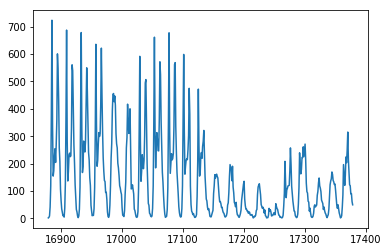

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
_ = bike_df['cnt'].iloc[-500:].plot()

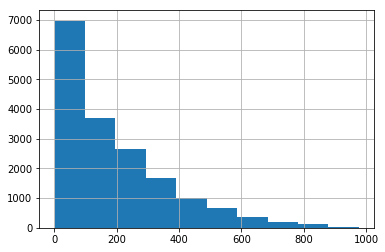

In [7]:
_ = bike_df['cnt'].hist()

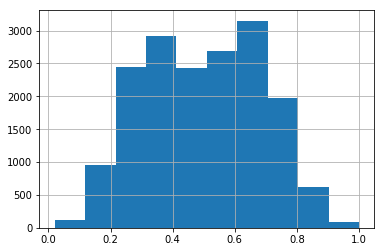

In [8]:
_ = bike_df['temp'].hist()

# 'cnt' is what we are trying to predict.  This is the number of people who rented bikes during that hour.

In [9]:
bike_df.shape

(17379, 13)

In [10]:
cols = bike_df.columns
feat_cols = [c for c in cols if c != 'cnt']
features = bike_df[feat_cols].values
targets = bike_df['cnt'].values

# for time series we typically want to save the last bit as the testing instead of mixing up the timesteps
trainsize = round(0.8 * features.shape[0])
train_features = features[:trainsize]
test_features = features[trainsize:]
train_targets = targets[:trainsize]
test_targets = targets[trainsize:]
print(train_targets.shape)
print(test_targets.shape)

(13903,)
(3476,)


In [11]:
# force to use CPU for testing
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# I ended up using my GPU so it would run much faster

In [12]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [13]:
features.shape[1]

12

In [14]:
# creates the model

# restart keras session (clear weights), sometimes this will clear up errors
K.clear_session()

# functional API
inputs = Input(shape=(features.shape[1], ))
x1 = Dense(10, activation='elu')(inputs)
x2 = BatchNormalization()(x1)
x3 = Dropout(0.5)(x2)
x = Dense(1, activation='linear')(x3)

In [15]:
# this saves the best model (lowest validation loss)
checkpoint = ModelCheckpoint('3_layer_dense.h5', monitor='val_loss', save_best_only=True)
# this stops training if the validation loss is not improving for 50 epochs in a row
es = EarlyStopping(patience=50)
cb = [checkpoint, es]

# this compiles our model so it is ready to fit
model = Model(inputs, x)
model.compile(optimizer='adam', loss='mse')

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                130       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 181
Trainable params: 161
Non-trainable params: 20
_________________________________________________________________


In [17]:
train_features.shape

(13903, 12)

In [18]:
subset_size = trainsize
train_feature_subset = train_features[:subset_size]
train_target_subset = train_targets[:subset_size]
# we actually fit the model here
history = model.fit(train_feature_subset,
                    train_target_subset,
                    epochs=500,
                    validation_split=0.15,
                    callbacks=cb,
                    batch_size=3000)

Train on 11817 samples, validate on 2086 samples
Epoch 1/500
11817/11817 [==============================] - 0s - loss: 46888.4853 - val_loss: 122681.0703
Epoch 2/500
11817/11817 [==============================] - 0s - loss: 46872.0337 - val_loss: 122608.2812
Epoch 3/500
11817/11817 [==============================] - 0s - loss: 46861.8252 - val_loss: 122535.3125
Epoch 4/500
11817/11817 [==============================] - 0s - loss: 46842.1859 - val_loss: 122463.2344
Epoch 5/500
11817/11817 [==============================] - 0s - loss: 46827.7098 - val_loss: 122395.5156
Epoch 6/500
11817/11817 [==============================] - 0s - loss: 46806.2726 - val_loss: 122330.0156
Epoch 7/500
11817/11817 [==============================] - 0s - loss: 46791.0079 - val_loss: 122267.0000
Epoch 8/500
11817/11817 [==============================] - 0s - loss: 46768.3556 - val_loss: 122206.0156
Epoch 9/500
11817/11817 [==============================] - 0s - loss: 46754.2355 - val_loss: 122147.9062
Epoch 

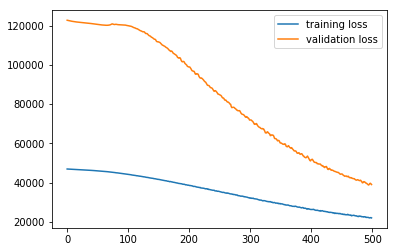

In [19]:
# check losses for overfitting and performance
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

0.0
0.133775503573


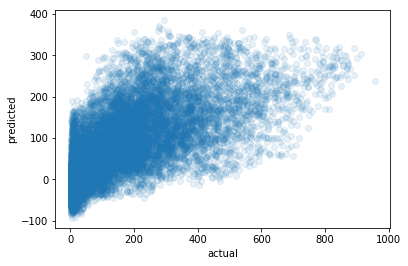

In [20]:
past_preds = model.predict(train_features)[:, 0]
future_preds = model.predict(test_features)[:, 0]

from sklearn.metrics import r2_score
import numpy as np

# our benchmark is just guessing the average
benchmark = np.mean(train_targets)
print(r2_score(train_targets, [benchmark] * train_targets.shape[0]))

print(r2_score(train_targets, past_preds))
plt.scatter(train_targets, past_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

-0.112995264662
0.150761437692


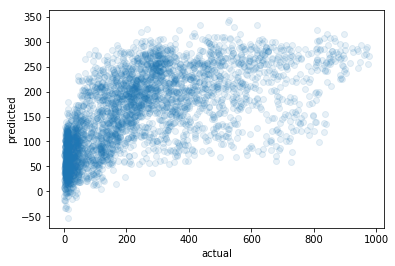

In [21]:
print(r2_score(test_targets, [benchmark] * test_targets.shape[0]))

print(r2_score(test_targets, future_preds))
plt.scatter(test_targets, future_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

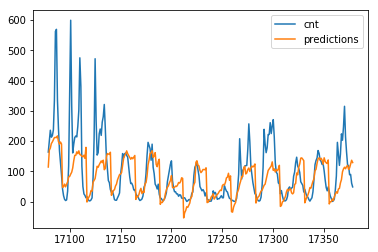

In [22]:
bike_df['cnt'].iloc[-300:].plot()
plt.plot(bike_df.index[-300:], future_preds[-300:], label='predictions')
_ = plt.legend()

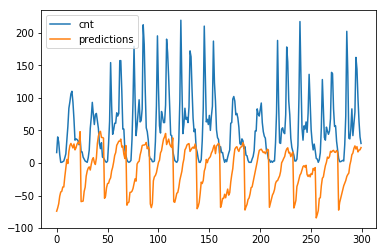

In [23]:
bike_df['cnt'].iloc[:300].plot()
plt.plot(bike_df.index[:300], past_preds[:300], label='predictions')
_ = plt.legend()

# now your turn: try different network hyperparameter settings and see which is best.  Recommendations:

* Change activation functions https://keras.io/activations/
* Change layer sizes
* Change number of layers
* Change dropout rate 
* loss function https://keras.io/losses/

Only do these one at a time.  Don't change network size, activation function, dropout rate all at the same time, or you wont know what made your net better or worse.

Advanced things to try:
* regularization (to prevent overfitting) https://keras.io/regularizers/
* mess around with optimizers https://keras.io/optimizers/
* use sklearn's StandardScaler to z-scale all your features http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [24]:
# try 2 -- make the first layer much larger

# creates the model

# restart keras session (clear weights), sometimes this will clear up errors
K.clear_session()

# functional API
inputs = Input(shape=(features.shape[1], ))
x1 = Dense(1000, activation='elu')(inputs)
x2 = BatchNormalization()(x1)
x3 = Dropout(0.5)(x2)
x = Dense(1, activation='linear')(x3)

# this saves the best model (lowest validation loss)
checkpoint = ModelCheckpoint('3_layer_dense.h5', monitor='val_loss', save_best_only=True)
# this stops training if the validation loss is not improving for 50 epochs in a row
es = EarlyStopping(patience=50)
cb = [checkpoint, es]

# this compiles our model so it is ready to fit
model = Model(inputs, x)
model.compile(optimizer='adam', loss='mse')

subset_size = trainsize
train_feature_subset = train_features[:subset_size]
train_target_subset = train_targets[:subset_size]
# we actually fit the model here
history = model.fit(train_feature_subset,
                    train_target_subset,
                    epochs=500,
                    validation_split=0.15,
                    callbacks=cb,
                    batch_size=3000)

Train on 11817 samples, validate on 2086 samples
Epoch 1/500
11817/11817 [==============================] - 0s - loss: 46644.8879 - val_loss: 121421.8906
Epoch 2/500
11817/11817 [==============================] - 0s - loss: 45949.8418 - val_loss: 119146.4531
Epoch 3/500
11817/11817 [==============================] - 0s - loss: 45262.4841 - val_loss: 116880.1406
Epoch 4/500
11817/11817 [==============================] - 0s - loss: 44649.2050 - val_loss: 114676.4688
Epoch 5/500
11817/11817 [==============================] - 0s - loss: 44095.9528 - val_loss: 112558.8984
Epoch 6/500
11817/11817 [==============================] - 0s - loss: 43608.7090 - val_loss: 110567.2969
Epoch 7/500
11817/11817 [==============================] - 0s - loss: 43150.2623 - val_loss: 108707.9844
Epoch 8/500
11817/11817 [==============================] - 0s - loss: 42729.6712 - val_loss: 107007.0938
Epoch 9/500
11817/11817 [==============================] - 0s - loss: 42345.8143 - val_loss: 105466.6250
Epoch 

benchmark r^2 on training: 0.0
training r^2: 0.559189680209


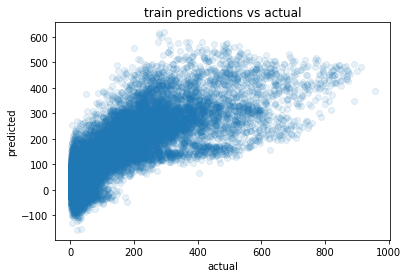

benchmark r^2 on test: -0.112995264662
r^2 on test: 0.501369302796


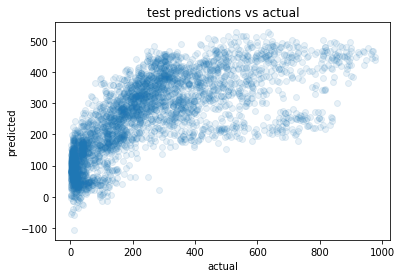

In [25]:
past_preds = model.predict(train_features)[:, 0]
future_preds = model.predict(test_features)[:, 0]

from sklearn.metrics import r2_score
import numpy as np

# our benchmark is just guessing the average
benchmark = np.mean(train_targets)
print('benchmark r^2 on training:', r2_score(train_targets, [benchmark] * train_targets.shape[0]))

print('training r^2:', r2_score(train_targets, past_preds))
plt.scatter(train_targets, past_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('train predictions vs actual')
plt.show()

print('benchmark r^2 on test:', r2_score(test_targets, [benchmark] * test_targets.shape[0]))

print('r^2 on test:', r2_score(test_targets, future_preds))
plt.scatter(test_targets, future_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('test predictions vs actual')
plt.show()

# An improvement from r^2 = 0.13 to 0.55 on the test just by increasing the first layer size from 10 to 1000.  Now we will add another layer of 500 neurons in the middle.

In [26]:
# creates the model

# restart keras session (clear weights), sometimes this will clear up errors
K.clear_session()

# functional API
inputs = Input(shape=(features.shape[1], ))
x1 = Dense(1000, activation='elu')(inputs)
x2 = BatchNormalization()(x1)
x3 = Dropout(0.5)(x2)
x4 = Dense(500, activation='elu')(x3)
x5 = BatchNormalization()(x4)
x6 = Dropout(0.5)(x5)
predictions = Dense(1, activation='linear')(x6)

# this saves the best model (lowest validation loss)
checkpoint = ModelCheckpoint('3_layer_dense.h5', monitor='val_loss', save_best_only=True)
# this stops training if the validation loss is not improving for 50 epochs in a row
es = EarlyStopping(patience=50)
cb = [checkpoint, es]

# this compiles our model so it is ready to fit
model = Model(inputs, predictions)
model.compile(optimizer='adam', loss='mse')

subset_size = trainsize
train_feature_subset = train_features[:subset_size]
train_target_subset = train_targets[:subset_size]
# we actually fit the model here
history = model.fit(train_feature_subset,
                    train_target_subset,
                    epochs=500,
                    validation_split=0.15,
                    callbacks=cb,
                    batch_size=3000)

Train on 11817 samples, validate on 2086 samples
Epoch 1/500
11817/11817 [==============================] - 0s - loss: 45779.7770 - val_loss: 107284.3594
Epoch 2/500
11817/11817 [==============================] - 0s - loss: 44322.8684 - val_loss: 98709.4922
Epoch 3/500
11817/11817 [==============================] - 0s - loss: 43922.3896 - val_loss: 95485.5469
Epoch 4/500
11817/11817 [==============================] - 0s - loss: 43559.1757 - val_loss: 95280.5625
Epoch 5/500
11817/11817 [==============================] - 0s - loss: 43111.6929 - val_loss: 96836.4766
Epoch 6/500
11817/11817 [==============================] - 0s - loss: 42594.0709 - val_loss: 99154.5312
Epoch 7/500
11817/11817 [==============================] - 0s - loss: 41992.6774 - val_loss: 100587.7500
Epoch 8/500
11817/11817 [==============================] - 0s - loss: 41331.2163 - val_loss: 100036.6094
Epoch 9/500
11817/11817 [==============================] - 0s - loss: 40728.4403 - val_loss: 96601.2422
Epoch 10/500

benchmark r^2 on training: 0.0
training r^2: 0.90947835224


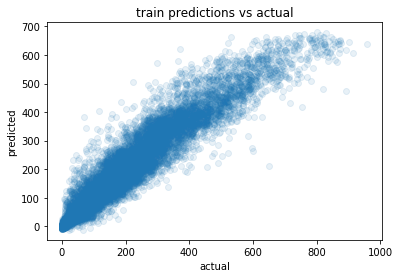

benchmark r^2 on test: -0.112995264662
r^2 on test: 0.82747418683


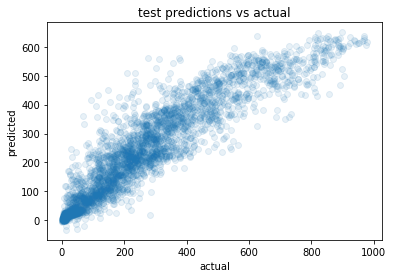

In [27]:
past_preds = model.predict(train_features)[:, 0]
future_preds = model.predict(test_features)[:, 0]

from sklearn.metrics import r2_score
import numpy as np

# our benchmark is just guessing the average
benchmark = np.mean(train_targets)
print('benchmark r^2 on training:', r2_score(train_targets, [benchmark] * train_targets.shape[0]))

print('training r^2:', r2_score(train_targets, past_preds))
plt.scatter(train_targets, past_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('train predictions vs actual')
plt.show()

print('benchmark r^2 on test:', r2_score(test_targets, [benchmark] * test_targets.shape[0]))

print('r^2 on test:', r2_score(test_targets, future_preds))
plt.scatter(test_targets, future_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('test predictions vs actual')
plt.show()

# Looking better but a bit of overfitting perhaps.  Adding one more layer in between the 500 and output

In [28]:
# creates the model

# restart keras session (clear weights), sometimes this will clear up errors
K.clear_session()

# functional API
inputs = Input(shape=(features.shape[1], ))
x1 = Dense(1000, activation='elu')(inputs)
x2 = BatchNormalization()(x1)
x3 = Dropout(0.5)(x2)
x4 = Dense(500, activation='elu')(x3)
x5 = BatchNormalization()(x4)
x6 = Dropout(0.5)(x5)
x7 = Dense(100, activation='elu')(x6)
x8 = BatchNormalization()(x7)
x9 = Dropout(0.5)(x8)
predictions = Dense(1, activation='linear')(x9)

# this saves the best model (lowest validation loss)
checkpoint = ModelCheckpoint('3_layer_dense.h5', monitor='val_loss', save_best_only=True)
# this stops training if the validation loss is not improving for 50 epochs in a row
es = EarlyStopping(patience=50)
cb = [checkpoint, es]

# this compiles our model so it is ready to fit
model = Model(inputs, predictions)
model.compile(optimizer='adam', loss='mse')

subset_size = trainsize
train_feature_subset = train_features[:subset_size]
train_target_subset = train_targets[:subset_size]
# we actually fit the model here
history = model.fit(train_feature_subset,
                    train_target_subset,
                    epochs=500,
                    validation_split=0.15,
                    callbacks=cb,
                    batch_size=3000)

Train on 11817 samples, validate on 2086 samples
Epoch 1/500
11817/11817 [==============================] - 0s - loss: 46293.1818 - val_loss: 110711.0703
Epoch 2/500
11817/11817 [==============================] - 0s - loss: 45548.6000 - val_loss: 106289.9609
Epoch 3/500
11817/11817 [==============================] - 0s - loss: 45292.6840 - val_loss: 107417.6719
Epoch 4/500
11817/11817 [==============================] - 0s - loss: 45085.7948 - val_loss: 110944.0156
Epoch 5/500
11817/11817 [==============================] - 0s - loss: 44870.0878 - val_loss: 114439.9609
Epoch 6/500
11817/11817 [==============================] - 0s - loss: 44663.1310 - val_loss: 116194.6094
Epoch 7/500
11817/11817 [==============================] - 0s - loss: 44443.6268 - val_loss: 114817.9609
Epoch 8/500
11817/11817 [==============================] - 0s - loss: 44252.9131 - val_loss: 111969.9453
Epoch 9/500
11817/11817 [==============================] - 0s - loss: 44066.5702 - val_loss: 109055.6875
Epoch 

benchmark r^2 on training: 0.0
training r^2: 0.929369672141


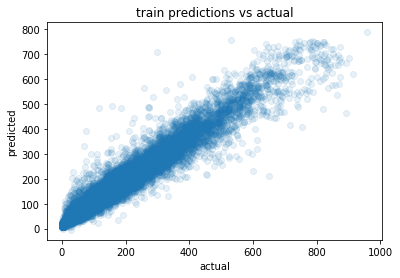

benchmark r^2 on test: -0.112995264662
r^2 on test: 0.829568217322


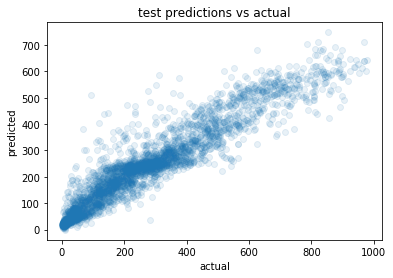

In [29]:
past_preds = model.predict(train_features)[:, 0]
future_preds = model.predict(test_features)[:, 0]

from sklearn.metrics import r2_score
import numpy as np

# our benchmark is just guessing the average
benchmark = np.mean(train_targets)
print('benchmark r^2 on training:', r2_score(train_targets, [benchmark] * train_targets.shape[0]))

print('training r^2:', r2_score(train_targets, past_preds))
plt.scatter(train_targets, past_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('train predictions vs actual')
plt.show()

print('benchmark r^2 on test:', r2_score(test_targets, [benchmark] * test_targets.shape[0]))

print('r^2 on test:', r2_score(test_targets, future_preds))
plt.scatter(test_targets, future_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('test predictions vs actual')
plt.show()

# a small impovement, we can probably get a little more performance by adding one more small layer before the output.

In [40]:
# creates the model

# restart keras session (clear weights), sometimes this will clear up errors
K.clear_session()

# functional API
inputs = Input(shape=(features.shape[1], ))
x1 = Dense(1000, activation='elu')(inputs)
x2 = BatchNormalization()(x1)
x3 = Dropout(0.5)(x2)
x4 = Dense(500, activation='elu')(x3)
x5 = BatchNormalization()(x4)
x6 = Dropout(0.5)(x5)
x7 = Dense(100, activation='elu')(x6)
x8 = BatchNormalization()(x7)
x9 = Dropout(0.5)(x8)
x10 = Dense(10, activation='elu')(x9)
x11 = BatchNormalization()(x10)
x12 = Dropout(0.5)(x11)
predictions = Dense(1, activation='linear')(x12)

# this saves the best model (lowest validation loss)
checkpoint = ModelCheckpoint('3_layer_dense.h5', monitor='val_loss', save_best_only=True)
# have to increase patience, because this larger net trains more slowly
es = EarlyStopping(patience=200)
cb = [checkpoint, es]

# this compiles our model so it is ready to fit
model = Model(inputs, predictions)
model.compile(optimizer='adam', loss='mse')

subset_size = trainsize
train_feature_subset = train_features[:subset_size]
train_target_subset = train_targets[:subset_size]
# we actually fit the model here
history = model.fit(train_feature_subset,
                    train_target_subset,
                    epochs=2000,
                    validation_split=0.15,
                    callbacks=cb,
                    batch_size=3000)

Train on 11817 samples, validate on 2086 samples
Epoch 1/2000
11817/11817 [==============================] - 0s - loss: 46636.5816 - val_loss: 114557.1172
Epoch 2/2000
11817/11817 [==============================] - 0s - loss: 46458.9378 - val_loss: 115334.9688
Epoch 3/2000
11817/11817 [==============================] - 0s - loss: 46387.2336 - val_loss: 118083.3359
Epoch 4/2000
11817/11817 [==============================] - 0s - loss: 46319.6015 - val_loss: 119970.7969
Epoch 5/2000
11817/11817 [==============================] - 0s - loss: 46269.9423 - val_loss: 120101.0391
Epoch 6/2000
11817/11817 [==============================] - 0s - loss: 46221.7992 - val_loss: 118859.5547
Epoch 7/2000
11817/11817 [==============================] - 0s - loss: 46166.6329 - val_loss: 117735.6016
Epoch 8/2000
11817/11817 [==============================] - 0s - loss: 46146.2623 - val_loss: 117252.5781
Epoch 9/2000
11817/11817 [==============================] - 0s - loss: 46119.5825 - val_loss: 116563.79

benchmark r^2 on training: 0.0
training r^2: 0.906318500515


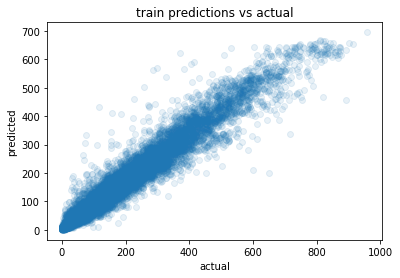

benchmark r^2 on test: -0.112995264662
r^2 on test: 0.748600396798


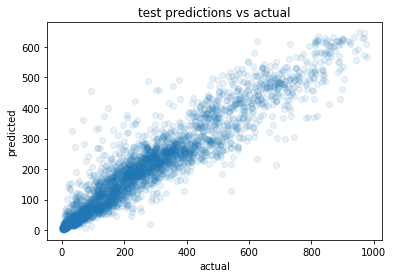

In [41]:
past_preds = model.predict(train_features)[:, 0]
future_preds = model.predict(test_features)[:, 0]

from sklearn.metrics import r2_score
import numpy as np

# our benchmark is just guessing the average
benchmark = np.mean(train_targets)
print('benchmark r^2 on training:', r2_score(train_targets, [benchmark] * train_targets.shape[0]))

print('training r^2:', r2_score(train_targets, past_preds))
plt.scatter(train_targets, past_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('train predictions vs actual')
plt.show()

print('benchmark r^2 on test:', r2_score(test_targets, [benchmark] * test_targets.shape[0]))

print('r^2 on test:', r2_score(test_targets, future_preds))
plt.scatter(test_targets, future_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('test predictions vs actual')
plt.show()

# performance didn't seem to improve much with the added last layer, so we will leave it out.  Checking effect of mean squared log error as the loss function:

In [42]:
# creates the model

# restart keras session (clear weights), sometimes this will clear up errors
K.clear_session()

# functional API
inputs = Input(shape=(features.shape[1], ))
x1 = Dense(1000, activation='elu')(inputs)
x2 = BatchNormalization()(x1)
x3 = Dropout(0.5)(x2)
x4 = Dense(500, activation='elu')(x3)
x5 = BatchNormalization()(x4)
x6 = Dropout(0.5)(x5)
x7 = Dense(100, activation='elu')(x6)
x8 = BatchNormalization()(x7)
x9 = Dropout(0.5)(x8)
predictions = Dense(1, activation='linear')(x9)

# this saves the best model (lowest validation loss)
checkpoint = ModelCheckpoint('3_layer_dense.h5', monitor='val_loss', save_best_only=True)
# this stops training if the validation loss is not improving for 50 epochs in a row
es = EarlyStopping(patience=50)
cb = [checkpoint, es]

# this compiles our model so it is ready to fit
model = Model(inputs, predictions)
model.compile(optimizer='adam', loss='msle')

subset_size = trainsize
train_feature_subset = train_features[:subset_size]
train_target_subset = train_targets[:subset_size]
# we actually fit the model here
history = model.fit(train_feature_subset,
                    train_target_subset,
                    epochs=500,
                    validation_split=0.15,
                    callbacks=cb,
                    batch_size=3000)

Train on 11817 samples, validate on 2086 samples
Epoch 1/500
11817/11817 [==============================] - 0s - loss: 14.8808 - val_loss: 5.8870
Epoch 2/500
11817/11817 [==============================] - 0s - loss: 11.9932 - val_loss: 5.8795
Epoch 3/500
11817/11817 [==============================] - 0s - loss: 11.0991 - val_loss: 7.2161
Epoch 4/500
11817/11817 [==============================] - 0s - loss: 10.4644 - val_loss: 9.3180
Epoch 5/500
11817/11817 [==============================] - 0s - loss: 10.1569 - val_loss: 10.5714
Epoch 6/500
11817/11817 [==============================] - 0s - loss: 9.9200 - val_loss: 9.6096
Epoch 7/500
11817/11817 [==============================] - 0s - loss: 9.6808 - val_loss: 8.2269
Epoch 8/500
11817/11817 [==============================] - 0s - loss: 9.4921 - val_loss: 7.6037
Epoch 9/500
11817/11817 [==============================] - 0s - loss: 9.3259 - val_loss: 7.6200
Epoch 10/500
11817/11817 [==============================] - 0s - loss: 9.1590 - v

benchmark r^2 on training: 0.0
training r^2: -0.031770368095


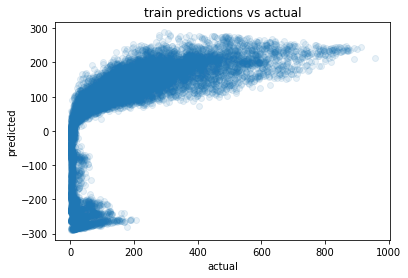

benchmark r^2 on test: -0.112995264662
r^2 on test: -0.0440845429422


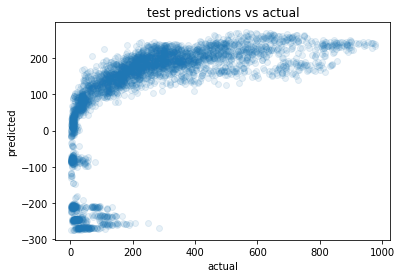

In [43]:
past_preds = model.predict(train_features)[:, 0]
future_preds = model.predict(test_features)[:, 0]

from sklearn.metrics import r2_score
import numpy as np

# our benchmark is just guessing the average
benchmark = np.mean(train_targets)
print('benchmark r^2 on training:', r2_score(train_targets, [benchmark] * train_targets.shape[0]))

print('training r^2:', r2_score(train_targets, past_preds))
plt.scatter(train_targets, past_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('train predictions vs actual')
plt.show()

print('benchmark r^2 on test:', r2_score(test_targets, [benchmark] * test_targets.shape[0]))

print('r^2 on test:', r2_score(test_targets, future_preds))
plt.scatter(test_targets, future_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('test predictions vs actual')
plt.show()

# this doesn't seem to work well, especially for the small values

In [47]:
# creates the model

# restart keras session (clear weights), sometimes this will clear up errors
K.clear_session()

# functional API
inputs = Input(shape=(features.shape[1], ))
x1 = Dense(1000, activation='elu')(inputs)
x2 = BatchNormalization()(x1)
x3 = Dropout(0.5)(x2)
x4 = Dense(500, activation='elu')(x3)
x5 = BatchNormalization()(x4)
x6 = Dropout(0.5)(x5)
x7 = Dense(100, activation='elu')(x6)
x8 = BatchNormalization()(x7)
x9 = Dropout(0.5)(x8)
predictions = Dense(1, activation='linear')(x9)

# this saves the best model (lowest validation loss)
checkpoint = ModelCheckpoint('3_layer_dense.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(patience=100)
cb = [checkpoint, es]

# this compiles our model so it is ready to fit
model = Model(inputs, predictions)
model.compile(optimizer='adam', loss='mape')

subset_size = trainsize
train_feature_subset = train_features[:subset_size]
train_target_subset = train_targets[:subset_size]
# we actually fit the model here
history = model.fit(train_feature_subset,
                    train_target_subset,
                    epochs=500,
                    validation_split=0.15,
                    callbacks=cb,
                    batch_size=3000)

Train on 11817 samples, validate on 2086 samples
Epoch 1/500
11817/11817 [==============================] - 0s - loss: 98.9253 - val_loss: 105.2798
Epoch 2/500
11817/11817 [==============================] - 0s - loss: 94.9841 - val_loss: 105.1519
Epoch 3/500
11817/11817 [==============================] - 0s - loss: 94.5545 - val_loss: 106.5328
Epoch 4/500
11817/11817 [==============================] - 0s - loss: 94.5050 - val_loss: 105.6232
Epoch 5/500
11817/11817 [==============================] - 0s - loss: 93.6285 - val_loss: 105.1990
Epoch 6/500
11817/11817 [==============================] - 0s - loss: 93.4309 - val_loss: 106.3109
Epoch 7/500
11817/11817 [==============================] - 0s - loss: 93.5454 - val_loss: 106.8793
Epoch 8/500
11817/11817 [==============================] - 0s - loss: 93.3973 - val_loss: 106.6835
Epoch 9/500
11817/11817 [==============================] - 0s - loss: 93.1791 - val_loss: 106.6913
Epoch 10/500
11817/11817 [==============================] - 

benchmark r^2 on training: 0.0
training r^2: 0.368044858342


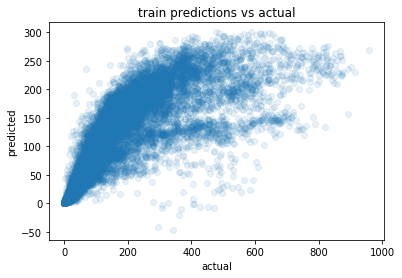

benchmark r^2 on test: -0.112995264662
r^2 on test: 0.142694982686


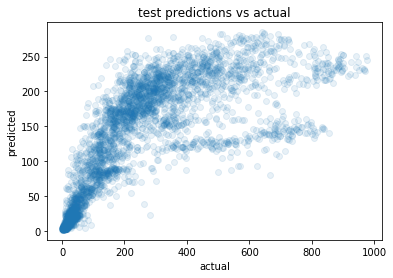

In [48]:
past_preds = model.predict(train_features)[:, 0]
future_preds = model.predict(test_features)[:, 0]

from sklearn.metrics import r2_score
import numpy as np

# our benchmark is just guessing the average
benchmark = np.mean(train_targets)
print('benchmark r^2 on training:', r2_score(train_targets, [benchmark] * train_targets.shape[0]))

print('training r^2:', r2_score(train_targets, past_preds))
plt.scatter(train_targets, past_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('train predictions vs actual')
plt.show()

print('benchmark r^2 on test:', r2_score(test_targets, [benchmark] * test_targets.shape[0]))

print('r^2 on test:', r2_score(test_targets, future_preds))
plt.scatter(test_targets, future_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('test predictions vs actual')
plt.show()

# mape doesn't seem to work well.  Both poisson and logcosh give NAN, so were unusable.  It seems the best network was 4 dense layers of sizes:

* 1000
* 500
* 100
* 1

And I used batchnormalization and dropout between each layer.  elu was the activator, and the best loss function seemed to be MSE.  The best r^2 was around 0.93 on train, and around 0.83 on test.